In [1]:
# script for processing the ICON+MS-GWaM data, output and filter results of MS-GWaM prametrisation 
# ploting routines for number of ocurances of large-scale vertical winds, leading ray volume vertical winds,
# corresponding frequency of the GW and momentum flux induced by the corresponding GW. Figure 3 

# date: 29.08.2024
# author: A. Kosareva


import netCDF4
import numpy as np
import math 
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import lib.lICONio as iio
import struct

In [2]:
# loading of the ICON output
# requires files: 
# and library 

# specify path to the grid data
base = '/home/administrator/Documents/ICON/test_for_ice_cloud_models/'
vgrd_path = base + '../data_grids/vgrid_DOM01_r2b5.nc'
grid_path = base + '../data_grids/icon_grid_0030_R02B05_G.nc'

# set nesessary day of the output
nday =18
# nday = 21

# specify path to ICON output file
file_1_fs = base +'../short_tests/gscp811_spgw_egu/with_ef_forcing/gws-0_DOM01_ML_201005'+str(nday)+'T000000Z.nc'
#     loading the output and specific parameters "clon_bnds", etc.
data1fs = iio.ICONIO(file_1_fs, grid_path, vgrid_path=vgrd_path)
data1fs.load_dataset('z_ifc',vgrid=True)


subset = np.where((np.rad2deg(data1fs.clat) >= -91) &
                  (np.rad2deg(data1fs.clat) <= 91) &
                  (np.rad2deg(data1fs.clon) >= -180) &
                  (np.rad2deg(data1fs.clon) <= 180))



In [3]:
# calculation of the momentum flux of GW from the vertical wind amplitude and frequency
def mom_flux(A,omega):
#     constants
    Rsp = 287 #J/kg/K
    T_00 = 210 #K
    p_00 = 30000 # Pa
    f0 = 1e-4 #1/s
    NN=0.02 #1/s
    rho = p_00/Rsp/T_00 # Pa/J*kg*K/K - >Pa /(kg m2/s2)*kg ->Pa *s2/m2
    freq = np.array(omega) # 1/s
    return (rho *((NN**2 - freq **2)/(freq**2-f0**2))**(0.5)*np.array(A)**2) #Pa

In [4]:
# filtering routine for ICON-MS-GWaM data
def filtering_w(w,om):
    w_filtered  = np.reshape(w,-1)
    om_filtered = np.reshape(om,-1)
#     filter cells with updrafts 
    om_filtered=om_filtered[np.where(w_filtered>0)]
    w_filtered = w_filtered[np.where(w_filtered>0)]
#     additional filter of cells with omega<f=1e-4 (Coriolis parameter)
    w_filtered = w_filtered[np.where(om_filtered>1e-4)]
    om_filtered=om_filtered[np.where(om_filtered>1e-4)]
    return w_filtered, om_filtered

In [5]:
#Save filtered data for further use in constructing the forcing term in the parcel model

#load the data for 1 day
nday =18
# nday = 21
if (nday<10):
    file_1_fs = base +'../short_tests/gscp811_spgw_egu/with_ef_forcing/gws-0_DOM01_ML_2010050'+str(nday)+'T000000Z.nc'
else:
    file_1_fs = base +'../short_tests/gscp811_spgw_egu/with_ef_forcing/gws-0_DOM01_ML_201005'+str(nday)+'T000000Z.nc'

data1fs = iio.ICONIO(file_1_fs, grid_path, vgrid_path=vgrd_path)
data1fs.load_dataset('z_ifc',vgrid=True)
data1fs.load_dataset('vert_vel_gwf')
data1fs.load_dataset('omega_gwf')
data1fs.load_dataset('phase_gwf')
data1fs.load_dataset("w")

# selecting the vertical boudaries relevant for cirrus 
height =8e3
vertical_index_bot = np.argmin(np.abs(height - data1fs.z_ifc[:, 0]))

height =14e3
vertical_index_top = np.argmin(np.abs(height - data1fs.z_ifc[:, 0]))

# saving the parameters w, hat{w}, omega
W_day = data1fs.vert_vel_gwf[0,vertical_index_top:vertical_index_bot,subset]
om_day =data1fs.omega_gwf[0,vertical_index_top:vertical_index_bot,subset]
w = np.reshape(np.array(data1fs.w[0,vertical_index_top:vertical_index_bot,subset]),-1)

#filter the data from zeros and irrelevant omegas 
w_filt,om1_filt =filtering_w(W_day,om_day)

#write to binary files 
handle = open('w_hat_'+str(nday)+'sample.dat', 'wb')
handle.write(struct.pack('<%dd' % len(w_filt), *w_filt))
handle.close()

handle = open('omega_'+str(nday)+'sample.dat', 'wb')
handle.write(struct.pack('<%dd' % len(om1_filt), *om1_filt))
handle.close()

handle = open('vertvel_'+str(nday)+'sample.dat', 'wb')
handle.write(struct.pack('<%dd' % len(w), *w))
handle.close()

print('Saved data set:', '\n w_hat_'+str(nday)+'sample.dat')


Saved data set: 
 w_hat_18sample.dat


In [6]:
# select data from 9 to 14 km

height =9e3
vertical_index_bot = np.argmin(np.abs(height - data1fs.z_ifc[:, 0]))

height =14e3
vertical_index_top = np.argmin(np.abs(height - data1fs.z_ifc[:, 0]))

W_day = data1fs.vert_vel_gwf[0,vertical_index_top:vertical_index_bot,subset]
om_day =data1fs.omega_gwf[0,vertical_index_top:vertical_index_bot,subset]
w = np.reshape(np.array(data1fs.w[0,vertical_index_top:vertical_index_bot,subset]),-1)
w_filt,om1_filt =filtering_w(W_day,om_day)

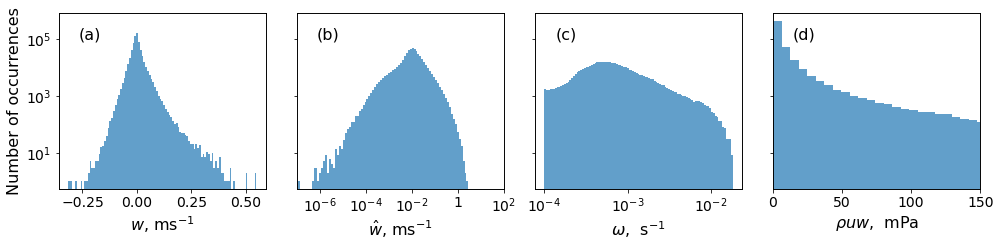

In [34]:
# plot Fig. 3
# data for number of ocurences of w, hat{w}, omega and rhouw momentum flux
# select the font size
fs = 16

# plot 4 histograms
fig, axs = plt.subplots(ncols =4, figsize=(14,3.5),sharey=True, tight_layout=True)

# w plot
axs[0].set_ylabel('Number of occurrences',fontsize = fs)
axs[0].hist((w), bins=105,alpha = 0.7)
axs[0].set_xlabel('$w$, ms$^{-1}$',fontsize = fs)


# hat{w} plot
ticksNpost = np.array([1e-6, 1e-4,1e-2, 1e0,1e2])
ticksNs = (["$10^{-6}$", "$10^{-4}$","$10^{-2}$", "$1$", "$10^{2}$"])
axs[1].hist(np.log(w_filt), bins=105,alpha = 0.7)
axs[1].set_xticks(np.log(ticksNpost), ticksNs,
       rotation=0)
axs[1].set_xlim(np.log(1e-7), np.log(1e2))
axs[1].set_xlabel('$\hat{w}$, ms$^{-1}$',fontsize = fs)

# omega plot
ticksNpost = np.array([1e-4, 1e-3, 1e-2])
ticksNs = (["$10^{-4}$", "$10^{-3}$", "$10^{-2}$"])
axs[2].set_xticks(np.log(ticksNpost), ticksNs,
       rotation=0)
# We can set the number of bins with the *bins* keyword argument.
axs[2].hist(np.log(om1_filt), bins=105,alpha = 0.7)
axs[2].set_xlabel('$\omega$,  s$^{-1}$',fontsize = fs)

# calculation and plot for momentum flux
mom_msgwam =  mom_flux(w_filt,om1_filt) #in Pa
axs[3].hist(mom_msgwam*1e3, bins=1000,alpha = 0.7)
axs[3].set_xlabel(r'$\rho u w$,  mPa',fontsize = fs)
axs[3].set_xlim(0,150)

for ax in axs.flat:
    ax.xaxis.set_tick_params(labelsize=fs-2)
    ax.yaxis.set_tick_params(labelsize=fs-2)
    ax.set_yscale('log')
ax1= ['','','','']
ax1_names= ['(a)','(b)','(c)','(d)']
for i in range(0,4):
    ax1[i]=axs[i].twiny()
    ax1[i].set_xlabel(ax1_names[i],fontsize = fs)
    ax1[i].set_xticks([])
    ax1[i].xaxis.set_label_coords(0.15,0.85)




plt.savefig('IC_plot_joined_log.png',bbox_inches='tight',dpi=300)
plt.show()